In [1]:
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from glob import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys

Populating the interactive namespace from numpy and matplotlib


## Globals

In [2]:
ttw = np.arange(0,45)
asp = np.arange(45,57)
groups = [ttw, asp]
topfile = 'act_site.pdb'
feat = coor.featurizer(topfile)

In [3]:
traj_list = glob('aligned/*as[12]-aligned.dcd')
inp = coor.source(traj_list, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',2000 / (inp.trajectory_length(0)),'ps')

('number of trajectories = ', 220)
('trajectory length = ', 1000)
('trajectory time step = ', 2, 'ps')


## Add cartesian coordinate features

In [4]:
feat.add_all()
print(inp.dimension())
print(inp.describe()[:10])

171
['Feature reader with following features', 'ATOM:TTW 39 N 0 x', 'ATOM:TTW 39 N 0 y', 'ATOM:TTW 39 N 0 z', 'ATOM:TTW 39 HN 1 x', 'ATOM:TTW 39 HN 1 y', 'ATOM:TTW 39 HN 1 z', 'ATOM:TTW 39 CA 2 x', 'ATOM:TTW 39 CA 2 y', 'ATOM:TTW 39 CA 2 z']


## TICA

### Plot TICA component for different TICA lag-times

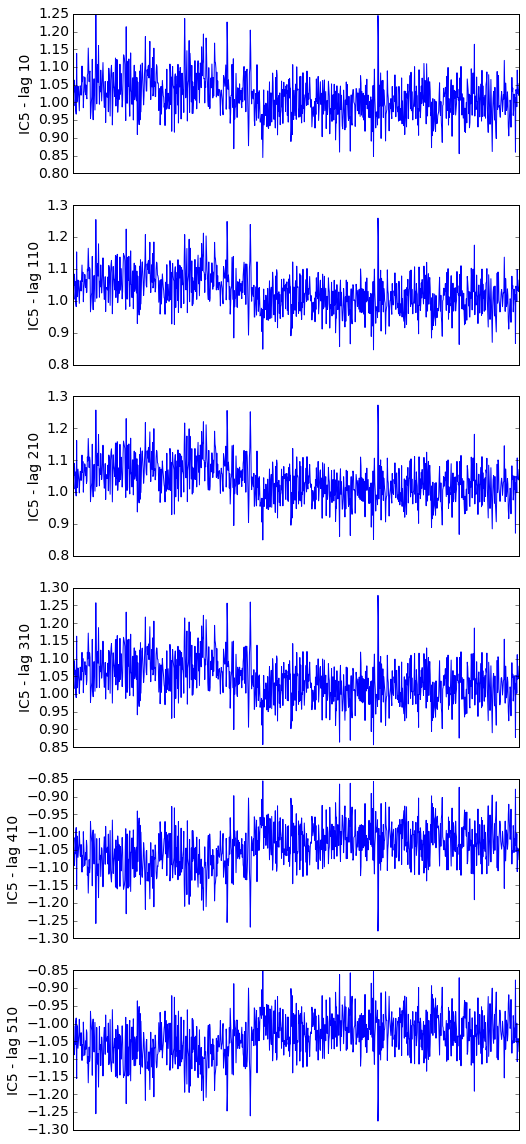

In [5]:
matplotlib.rcParams.update({'font.size': 14})
dt = 1
figure(figsize(8,20))
# TICA lag times
tica_lags=np.arange(10,511, 100)
# TICA component to plot
tica_comp = 5
N = len(tica_lags)
ax1=plt.subplot(N,1,1)
for i, tica_lag in enumerate(tica_lags):
    tica_obj = coor.tica(inp, lag=tica_lag, dim=tica_comp, kinetic_map=True)
    Y = tica_obj.get_output()
    ax1=plt.subplot(N,1,i+1)
    y = Y[0][:,tica_comp-1] #(Y[0][:,i] - np.mean(Y[0][:,i]))/np.std(Y[0][:,i])
    plot(y); ylabel('IC{} - lag {}'.format(tica_comp, tica_lag)); xticks([])

### Choose TICA lag time and get CVs

('TICA dimension: ', 11)
TICA cumulative variance:


(0, 20)

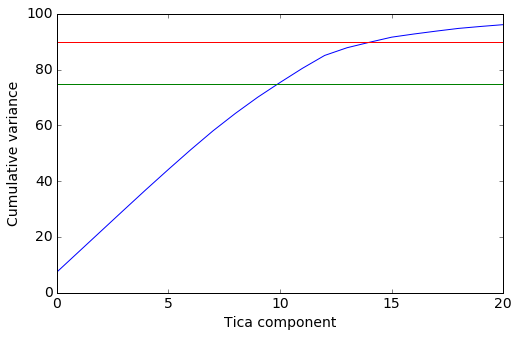

In [6]:
tica_lag=100
var_cut=75./100
tica_obj = coor.tica(inp, lag=tica_lag,var_cutoff=var_cut, kinetic_map=True)

print('TICA dimension: ', tica_obj.dimension())
print('TICA cumulative variance:')
figure(figsize(8,5))

plt.plot(tica_obj.cumvar*100)
plt.plot(np.repeat(75, 100))
plt.plot(np.repeat(90, 100))
plt.xlabel('Tica component')
plt.ylabel('Cumulative variance')
plt.xlim((0,20))

In [7]:
# for i in range(171):
#     if tica_obj.eigenvectors[0, i] > 0:
#         tica_obj.eigenvectors[:, i] *= -1

In [8]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])


('number of trajectories = ', 220)
('number of frames = ', 1000)
('number of dimensions = ', 11)


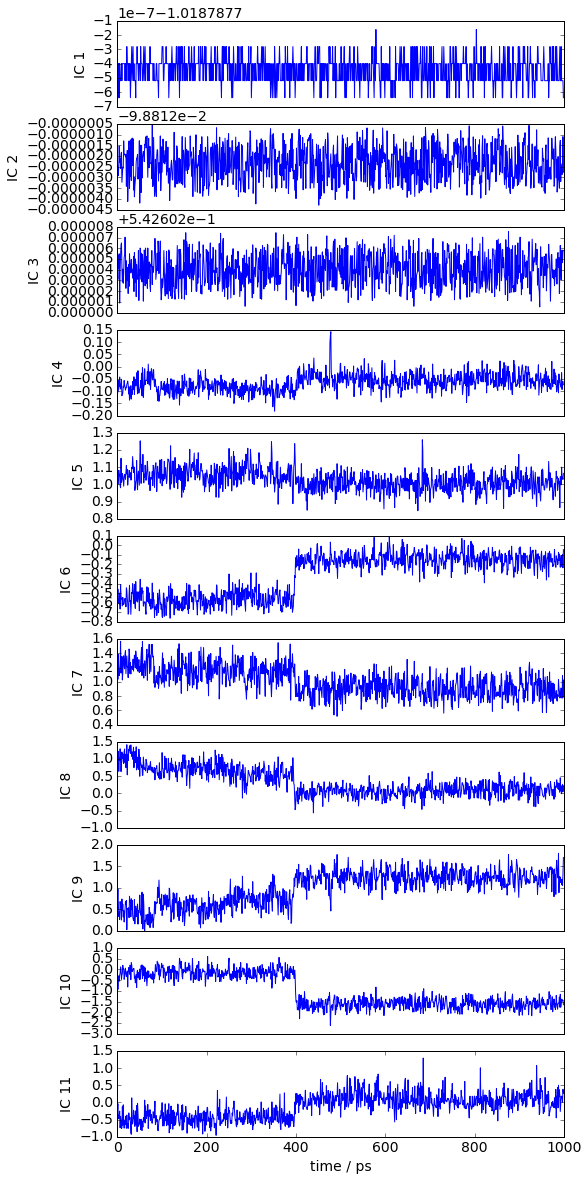

In [9]:
N = np.shape(Y)[2]
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(8,20))
ax1=plt.subplot(N,1,1)
x = dt*np.arange(Y[0].shape[0])
for i in range(N-1):
    ax1=plt.subplot(N,1,i+1)
    y = Y[0][:,i] #(Y[0][:,i] - np.mean(Y[0][:,i]))/np.std(Y[0][:,i])
    plot(x, y); ylabel('IC {}'.format(i+1)); xticks([])
#     ylim((-3,3))
    
ax1=plt.subplot(N,1,N)
plot(x, Y[0][:,N-1]); xlabel('time / ps'); ylabel('IC {}'.format(N)); 

## Cluster

In [10]:
n_clusters = 250      # number of k-means clusters
clustering = coor.cluster_kmeans(Y,k=n_clusters)


23-01-17 09:25:16 pyemma.coordinates.clustering.kmeans.KmeansClustering[7] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [11]:
dtrajs = clustering.dtrajs


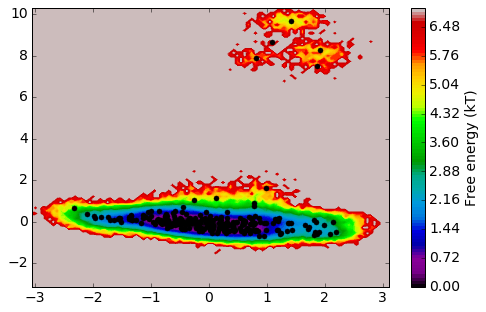

In [12]:
figure(figsize(8,5))
i, j = 9,10
mplt.plot_free_energy(np.vstack(Y)[:,i], np.vstack(Y)[:,j])
cc_x = clustering.clustercenters[:,i]
cc_y = clustering.clustercenters[:,j]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

## MSM

In [13]:
its = msm.timescales_msm(dtrajs, lags=np.arange(100,1000,100), nits=10)


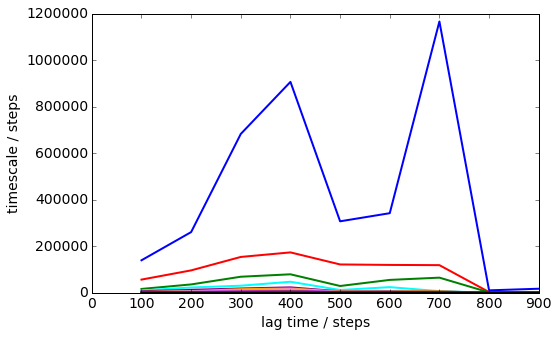

In [14]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)
# xlim(0, 40); ylim(0, 120);

In [15]:
msm_lag = 400
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

('fraction of states used = ', 0.12)
('fraction of counts used = ', 0.13309545454545454)


In [16]:
hmm = M.coarse_grain(5)